# EDA

In [1]:
# Importación de librerías
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import folium

# Creación de dataframe
df = pd.read_csv("./roman-emperors.csv.xls")

# Eliminación columnas innecesarias
df = df.drop('Notes', axis=1)
df = df.drop('Verif', axis=1)
df = df.drop('Image', axis=1)
df = df.drop('Unnamed: 17', axis=1)
df = df.drop('Unnamed: 19', axis=1)
df = df.drop('Unnamed: 18', axis=1)



In [2]:
# Ajuste del index
df = (df.reset_index()
        .drop_duplicates(subset='Index', keep='last')
        .set_index('Index').sort_index())

df = df.drop('index', axis=1)

In [3]:
# Completar datos nulos del df
df.loc[44, 'Birth'] = "0232-01-01T00:53:28+00:53"
df.loc[47, 'Birth'] = "0253-01-01T00:53:28+00:53"
df.loc[48, 'Birth'] = "0250-01-01T00:53:28+00:53"
df.loc[53, 'Birth'] = "0250-01-01T00:53:28+00:53"
df.loc[61, 'Birth'] = "0270-01-01T00:53:28+00:53"

In [4]:
# Calculo de fechas
df['Birth'] = df['Birth'].apply(lambda x: x.split('T')[0] if isinstance(x, str) and 'T' in x else x)
df['Death'] = df['Death'].apply(lambda x: x.split('T')[0] if isinstance(x, str) and 'T' in x else x)
df['Birth'] = df['Birth'].apply(lambda x: '-'.join(x.split('-')[::-1]) if isinstance(x, str) else x)
df['Death'] = df['Death'].apply(lambda x: '-'.join(x.split('-')[::-1]) if isinstance(x, str) else x)

df['Reign Start'] = df['Reign Start'].apply(lambda x: x.split('T')[0] if isinstance(x, str) and 'T' in x else x)
df['Reign End'] = df['Reign End'].apply(lambda x: x.split('T')[0] if isinstance(x, str) and 'T' in x else x)
df['Reign Start'] = df['Reign Start'].apply(lambda x: '-'.join(x.split('-')[::-1]) if isinstance(x, str) else x)
df['Reign End'] = df['Reign End'].apply(lambda x: '-'.join(x.split('-')[::-1]) if isinstance(x, str) else x)


In [5]:
# Convertir cadenas a objetos datetime
df['Birth'] = df['Birth'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
df['Death'] = df['Death'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
df['Reign Start'] = df['Reign Start'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
df['Reign End'] = df['Reign End'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))

# Calcular años vividos
df['Años Vividos'] = df.apply(
    lambda row: (row['Death'].year - row['Birth'].year) - 
                (1 if (row['Death'].month, row['Death'].day) < (row['Birth'].month, row['Birth'].day) else 0),
    axis=1
)

df['Años Gobernados'] = df.apply(
    lambda row: (row['Reign End'].year - row['Reign Start'].year) - 
                (1 if (row['Reign End'].month, row['Reign End'].day) < (row['Reign Start'].month, row['Reign Start'].day) else 0),
    axis=1
)

In [6]:
# Introducir datos para los casos donde hay años antes de Cristo, los cuales python no maneja
df.loc[1, 'Años Vividos'] = 75
df.loc[2, 'Años Vividos'] = 77
df.loc[4, 'Años Vividos'] = 63

df.loc[1, 'Años Gobernados'] = 41
df.loc[2, 'Años Gobernados'] = 23


In [7]:
df.head()

,Name,Full Name,Birth,Death,Birth City,Birth Province,Succession,Reign Start,Reign End,Cause,Killer,Dynasty,Era,Años Vividos,Años Gobernados
Index,,,,,,,,,,,,,,,
1,Augustus,IMPERATOR CAESAR DIVI FILIVS AVGVSTVS,0063-09-23 00:00:00,0014-08-19 00:00:00,Rome,Italia,Birthright,0026-01-16 00:00:00,0014-08-19 00:00:00,Assassination,Wife,Julio-Claudian,Principate,75,41
2,Tiberius,TIBERIVS CAESAR DIVI AVGVSTI FILIVS AVGVSTVS,0041-11-16 00:00:00,0037-03-16 00:00:00,Rome,Italia,Birthright,0014-09-18 00:00:00,0037-03-16 00:00:00,Assassination,Other Emperor,Julio-Claudian,Principate,77,23
3,Caligula,GAIVS IVLIVS CAESAR AVGVSTVS GERMANICVS,0012-08-31 00:00:00,0041-01-24 00:00:00,Antitum,Italia,Birthright,0037-03-18 00:00:00,0041-01-24 00:00:00,Assassination,Senate,Julio-Claudian,Principate,28,3
4,Claudius,TIBERIVS CLAVDIVS CAESAR AVGVSTVS GERMANICVS,0009-08-01 00:00:00,0054-10-13 00:00:00,Lugdunum,Gallia Lugdunensis,Birthright,0041-01-25 00:00:00,0054-10-13 00:00:00,Assassination,Wife,Julio-Claudian,Principate,63,13
5,Nero,NERO CLAVDIVS CAESAR AVGVSTVS GERMANICVS,0037-12-15 00:00:00,0068-06-09 00:00:00,Antitum,Italia,Birthright,0054-10-13 00:00:00,0068-06-09 00:00:00,Suicide,Senate,Julio-Claudian,Principate,30,13


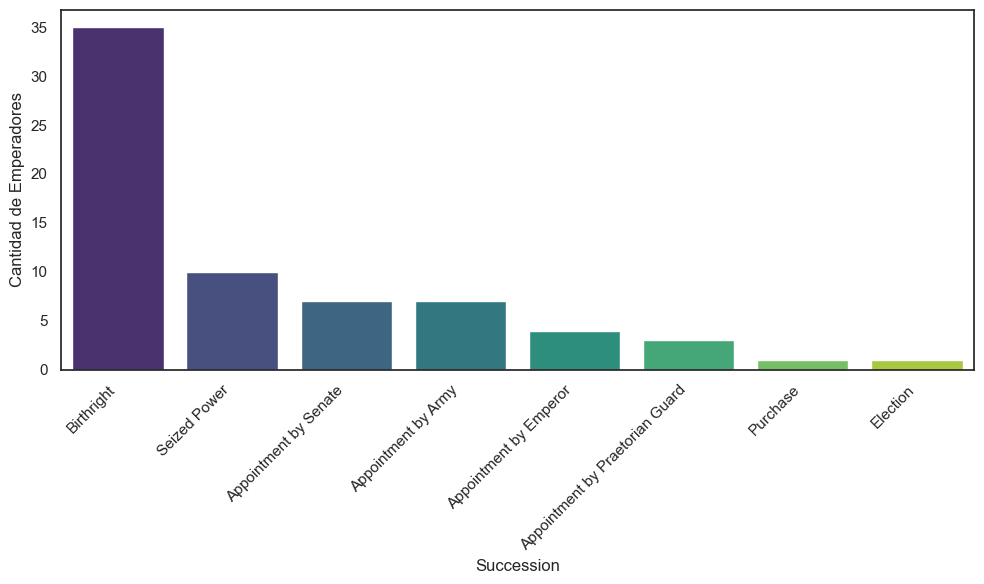

In [8]:
df['Succession'] = df['Succession'].astype(str)

# Contar las ocurrencias de cada tipo de sucesión
sucesion_counts = df['Succession'].value_counts().reset_index()
sucesion_counts.columns = ['Succession', 'Cantidad']

# Establecer el estilo de Seaborn para gráficos atractivos
sns.set(style="white")

# Crear la gráfica de barras usando 'hue'
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Succession', y='Cantidad', data=sucesion_counts, palette="viridis", hue='Succession')

plt.ylabel('Cantidad de Emperadores', fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotar etiquetas del eje x para mejor legibilidad

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [9]:
# Birthright - Cases in which an emperor's lineage was the determining factor in their control of the Empire, with little conflict.
# Seized Power - Cases in which an emporor used violent force, self-proclamation, or clever opportunism to seize the Empire without birthright or appointment.
# Appointment by X - Cases in which an emperor was appointed by an Army, the Senate, an Emperor, or Praetorian Guard.
# Other rare occurrences include Election.

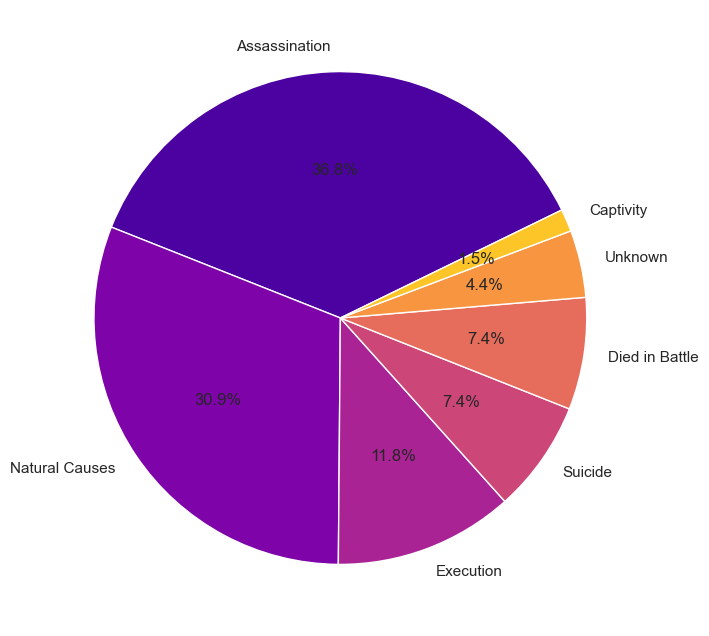

In [10]:
# Asegurarse de que 'Causas de Muerte' sea una columna de texto
df['Cause'] = df['Cause'].astype(str)

# Contar las ocurrencias de cada causa de muerte
causas_counts = df['Cause'].value_counts()

# Establecer el estilo de Seaborn para gráficos atractivos
sns.set(style="whitegrid")

# Crear el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(causas_counts, labels=causas_counts.index, autopct='%1.1f%%', startangle=26, colors=sns.color_palette("plasma", len(causas_counts)))

# Mostrar la gráfica
plt.show()


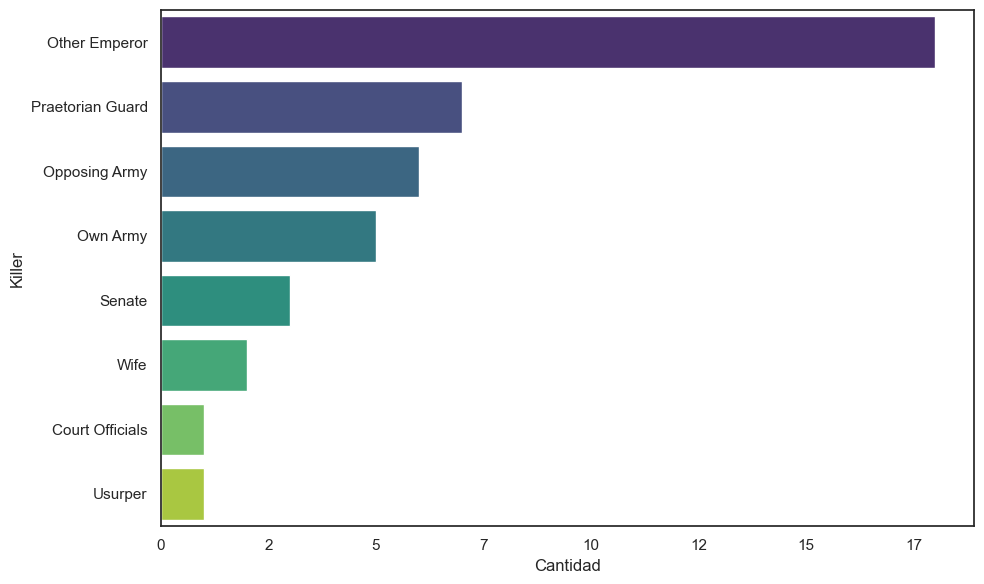

In [11]:
valores_permitidos = ['Other Emperor', 'Praetorian Guard', 'Opposing Army', 'Own Army', 'Senate', 'Wife', 'Usurper', 'Court Officials']
df_filtrado = df[df['Killer'].isin(valores_permitidos)]

# Contar las ocurrencias de cada tipo de sucesión
sucesion_counts = df_filtrado['Killer'].value_counts().reset_index()
sucesion_counts.columns = ['Killer', 'Cantidad']

# Establecer el estilo de Seaborn para gráficos atractivos
sns.set(style="white")

# Crear la gráfica de barras usando 'hue'
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cantidad', y='Killer', data=sucesion_counts, palette="viridis", hue='Killer')

# Eliminar los decimales del eje X
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

# Mostrar la gráfica
plt.tight_layout()
plt.show()

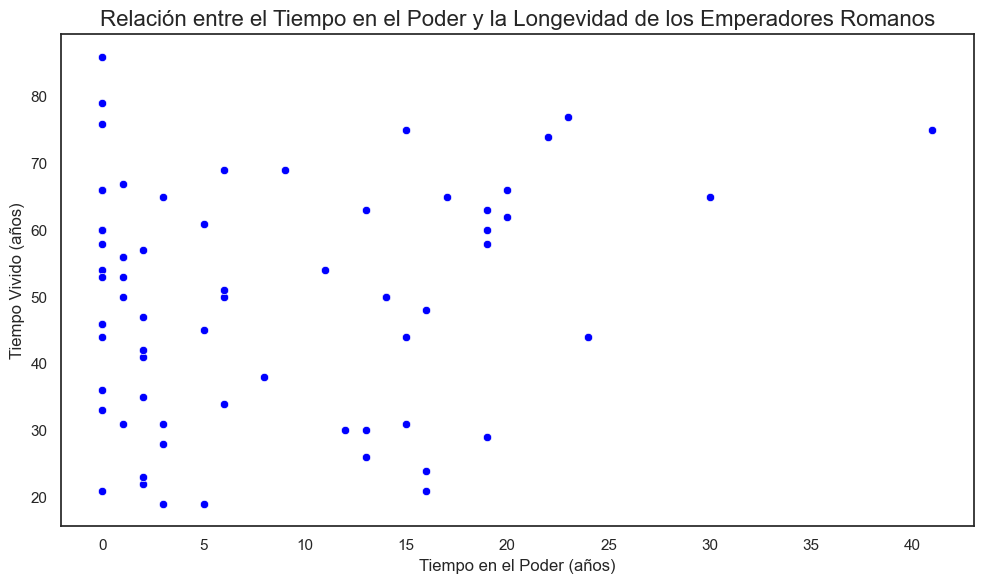

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Años Gobernados'], y=df['Años Vividos'], color='blue')

# Añadir título y etiquetas
plt.title('Relación entre el Tiempo en el Poder y la Longevidad de los Emperadores Romanos', fontsize=16)
plt.xlabel('Tiempo en el Poder (años)', fontsize=12)
plt.ylabel('Tiempo Vivido (años)', fontsize=12)

# Ajustar las marcas del eje X para que sean de 5 en 5
plt.xticks(range(0, int(df['Años Gobernados'].max()) + 1, 5))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

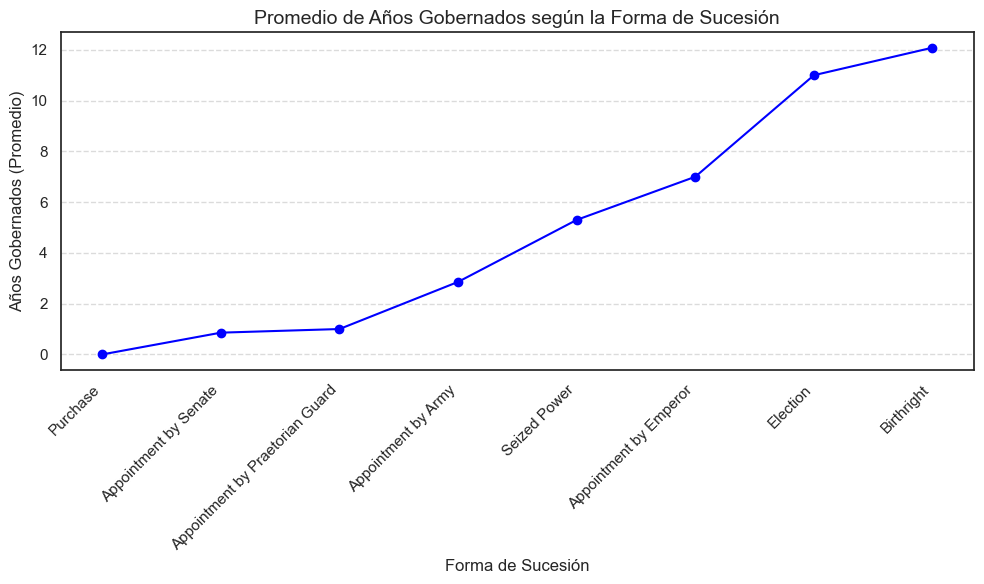

In [13]:
avg_years = df.groupby('Succession')['Años Gobernados'].mean().sort_values()

# Crear la gráfica de líneas
plt.figure(figsize=(10, 6))
avg_years.plot(kind='line', marker='o', color='blue')

# Personalización del gráfico
plt.title('Promedio de Años Gobernados según la Forma de Sucesión', fontsize=14)
plt.xlabel('Forma de Sucesión', fontsize=12)
plt.ylabel('Años Gobernados (Promedio)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

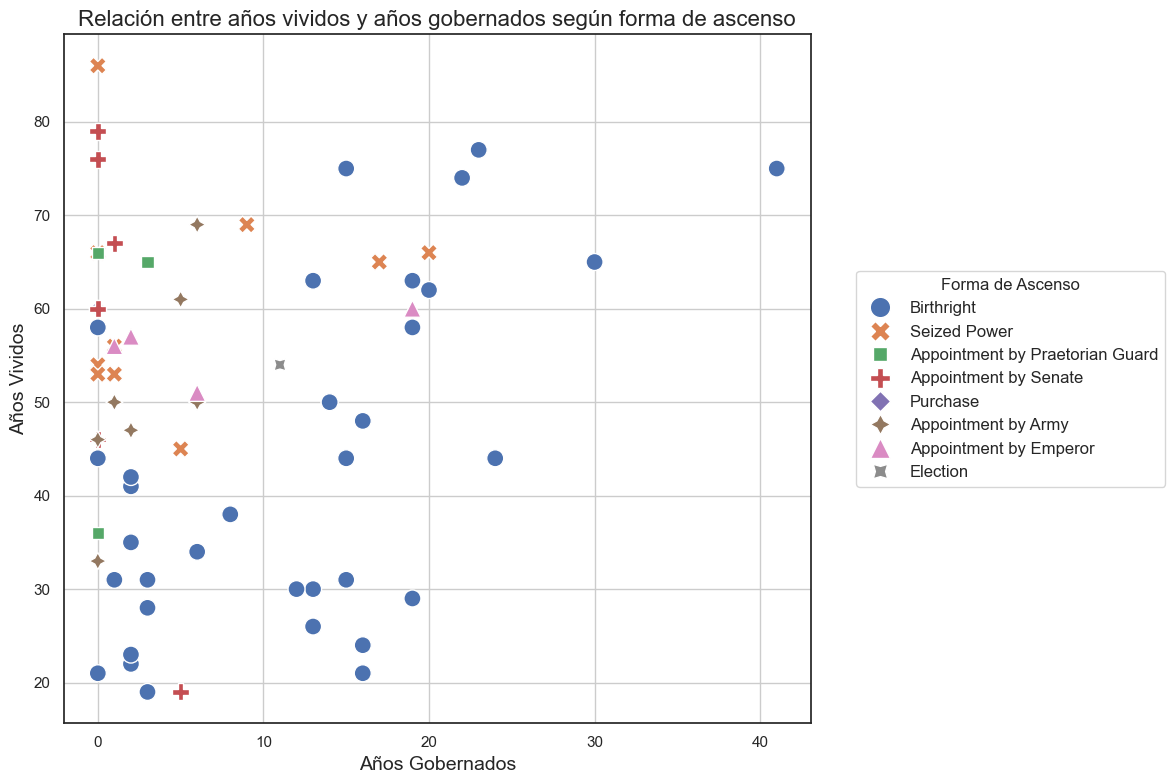

In [14]:
# Crear la figura más grande
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x="Años Gobernados", 
    y="Años Vividos", 
    hue="Succession",
    style="Succession",
    data=df, 
    s=150  # Tamaño de los puntos
)

# Personalización del gráfico
plt.xlabel("Años Gobernados", fontsize=14)
plt.ylabel("Años Vividos", fontsize=14)
plt.title("Relación entre años vividos y años gobernados según forma de ascenso", fontsize=16)
plt.grid(True)

# Ajustar la posición de la leyenda fuera del gráfico
plt.legend(
    title="Forma de Ascenso", 
    bbox_to_anchor=(1.05, 0.5), 
    loc='center left', 
    fontsize=12,
    markerscale=1.2
)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

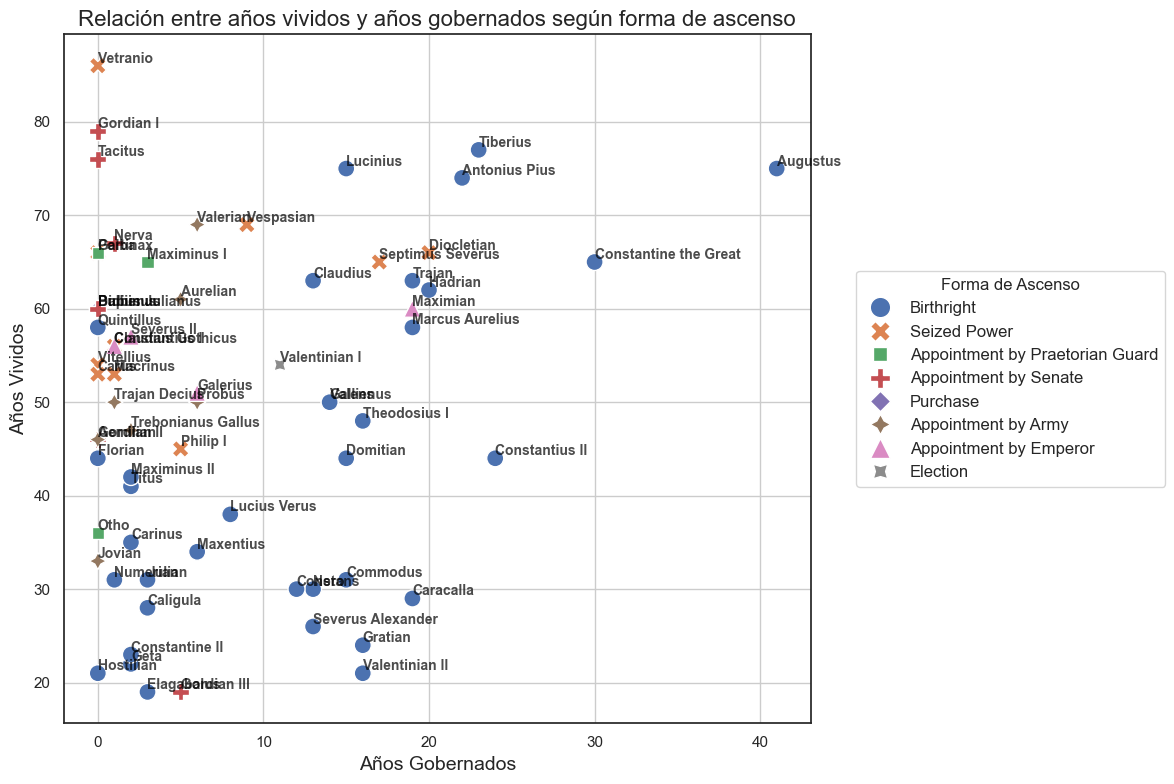

In [15]:

# Crear la figura más grande
plt.figure(figsize=(12, 8)) 
scatter_plot = sns.scatterplot(
    x="Años Gobernados", 
    y="Años Vividos", 
    hue="Succession",
    style="Succession",
    data=df, 
    s=150  # Tamaño de los puntos
)

# Personalización del gráfico
plt.xlabel("Años Gobernados", fontsize=14)
plt.ylabel("Años Vividos", fontsize=14)
plt.title("Relación entre años vividos y años gobernados según forma de ascenso", fontsize=16)
plt.grid(True)

# Añadir los nombres de los emperadores al lado de los puntos
for i in range(len(df)):
    plt.text(
        df['Años Gobernados'].iloc[i], 
        df['Años Vividos'].iloc[i], 
        df['Name'].iloc[i],
        fontsize=10, 
        ha='left', 
        va='bottom', 
        color='black',
        alpha=0.7, 
        fontweight='bold'
    )

# Ajustar la posición de la leyenda fuera del gráfico
plt.legend(
    title="Forma de Ascenso", 
    bbox_to_anchor=(1.05, 0.5), 
    loc='center left', 
    fontsize=12,
    markerscale=1.2 
)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [16]:
print(df.loc[df['Name'] == 'Marcus Aurelius', ['Name', 'Cause', 'Años Gobernados', 'Años Vividos']])
print(df.loc[df['Name'] == 'Commodus', ['Name', 'Cause', 'Años Gobernados', 'Años Vividos']])
print(df.loc[df['Name'] == 'Caracalla', ['Name', 'Cause', 'Años Gobernados', 'Años Vividos']])
print(df.loc[df['Name'] == 'Geta', ['Name', 'Cause', 'Años Gobernados', 'Años Vividos']])



                  Name           Cause  Años Gobernados  Años Vividos
Index                                                                
16     Marcus Aurelius  Natural Causes               19            58
           Name          Cause  Años Gobernados  Años Vividos
Index                                                        
18     Commodus  Assassination               15            31
            Name          Cause  Años Gobernados  Años Vividos
Index                                                         
22     Caracalla  Assassination               19            29
       Name          Cause  Años Gobernados  Años Vividos
Index                                                    
23     Geta  Assassination                2            22


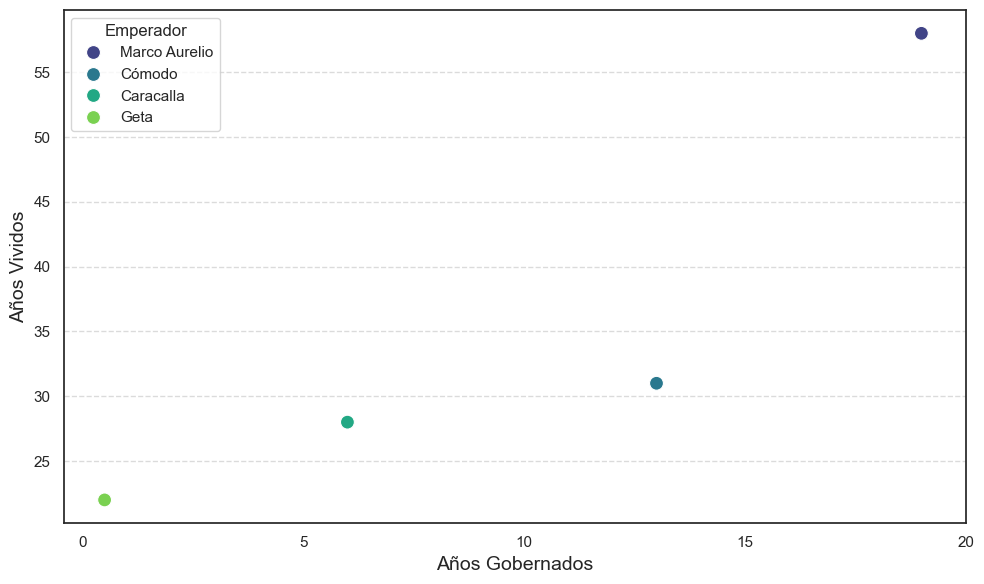

In [17]:
# De cara a la presentación, para mayor rigor histórico he utilizado estos datos de la Wikipedia en vez de los del dataset de Kaggle
emperadores_data = {
    'Emperador': ['Marco Aurelio', 'Cómodo', 'Caracalla', 'Geta'],
    'Años Gobernados': [19, 13, 6, 0.5],
    'Años Vividos': [58, 31, 28, 22]
}

# Crear el DataFrame
df_emperadores = pd.DataFrame(emperadores_data)

# Crear el scatterplot sin decimales en el eje x
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_emperadores, x='Años Gobernados', y='Años Vividos', s=100, hue='Emperador', palette='viridis')


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Años Gobernados", fontsize=14)
plt.ylabel("Años Vividos", fontsize=14)

# Eliminar los decimales en el eje x
plt.xticks(ticks=[0, 5, 10, 15, 20])

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [18]:
#Extracción de ciudades para crear un nuevo dataframe con sus coordenadas
valores_unicos = df['Birth City'].unique()

# Imprimir los valores únicos
print("Valores únicos en la columna 'Birth City':")
for valor in valores_unicos:
    print(valor)

Valores únicos en la columna 'Birth City':
Rome
Antitum
Lugdunum
Terracina
Terentinum
Falacrine
Narni
Italica
Lanuvium
Alba
Milan
Leptis Magna
Iol Caesarea
Emesa
Arca Caesarea
nan
Shahba
Budalia
Sirmium
Interamna Nahars
Narbo
Salona
Dardania
Romuliana
Naissus
Felix Romuliana
Arelate
Constantinople
Singidunum
Cibalae
Cauca


In [19]:
data = {
    "Ciudad": [
        "Rome", "Antium", "Lugdunum", "Terracina", "Terentinum", "Falacrine", "Narni", "Italica",
        "Lanuvium", "Alba", "Milan", "Leptis Magna", "Iol Caesarea", "Emesa", "Arca Caesarea",
        "Shahba", "Budalia", "Sirmium", "Interamna Nahars", "Narbo", "Salona", "Dardania", 
        "Romuliana", "Naissus", "Felix Romuliana", "Arelate", "Constantinople", "Singidunum",
        "Cibalae", "Cauca"
    ],
    "Latitud": [
        41.9028, 41.4548, 45.7679, 41.2900, 42.4250, 42.7167, 42.5167, 37.4387, 41.6700, 
        42.4192, 45.4642, 32.6370, 36.8190, 34.6610, 34.5295, 32.8400, 44.0703, 44.9840, 
        42.4725, 43.1845, 43.5200, 42.7984, 43.8900, 43.3209, 43.8900, 43.6767, 41.0082, 
        44.8176, 45.1614, 41.8060
    ],
    "Longitud": [
        12.4964, 12.6216, 4.8340, 13.2500, 14.2450, 13.0833, 12.5167, -6.0459, 12.6745, 
        13.0350, 9.1918, 14.2903, 3.5755, 36.1040, 36.0035, 36.5700, 21.4050, 19.6100, 
        12.8003, 3.0000, 16.4392, 21.1000, 22.0806, 21.8954, 22.0806, 4.6283, 28.9784, 
        20.4573, 18.6973, -4.7690
    ]
}

df_ciudades = pd.DataFrame(data)

# Crear un mapa centrado en el Mediterráneo
mapa = folium.Map(location=[41.9028, 12.4964], zoom_start=5)  # Centrado en Roma

# Contar las ocurrencias de cada ciudad en df
city_counts = df['Birth City'].value_counts()

# Crear un diccionario para buscar rápidamente las coordenadas de las ciudades
ciudades_coords = dict(zip(df_ciudades['Ciudad'], zip(df_ciudades['Latitud'], df_ciudades['Longitud'])))

# Función para determinar el color del marcador según la cantidad de repeticiones
def get_marker_color(count):
    if count >= 4:
        return 'red'
    elif count == 3:
        return 'green'
    elif count == 2:
        return 'purple'
    else:
        return 'blue'

# Iterar sobre el DataFrame df y agregar marcadores
for _, row in df.iterrows():
    ciudad = row['Birth City']
    if pd.notna(ciudad) and ciudad in ciudades_coords:
        lat, lon = ciudades_coords[ciudad]
        count = city_counts[ciudad]
        color = get_marker_color(count)
        
        # Agregar marcador con un círculo blanco dentro
        folium.Marker(
            location=[lat, lon],
            popup=f"Ciudad: {ciudad} - Repetida {count} veces",
            icon=folium.Icon(icon="location-crosshairs", prefix='fa', color=color)
        ).add_to(mapa)

# Guardar el mapa en un archivo HTML
mapa.save("mapa_emperadores_circulo.html")

print("Mapa guardado como 'mapa_emperadores_circulo.html'.")


Mapa guardado como 'mapa_emperadores_circulo.html'.


In [20]:
pd.set_option('display.max_rows', None)
df.head(len(df))

,Name,Full Name,Birth,Death,Birth City,Birth Province,Succession,Reign Start,Reign End,Cause,Killer,Dynasty,Era,Años Vividos,Años Gobernados
Index,,,,,,,,,,,,,,,
1,Augustus,IMPERATOR CAESAR DIVI FILIVS AVGVSTVS,0063-09-23 00:00:00,0014-08-19 00:00:00,Rome,Italia,Birthright,0026-01-16 00:00:00,0014-08-19 00:00:00,Assassination,Wife,Julio-Claudian,Principate,75,41
2,Tiberius,TIBERIVS CAESAR DIVI AVGVSTI FILIVS AVGVSTVS,0041-11-16 00:00:00,0037-03-16 00:00:00,Rome,Italia,Birthright,0014-09-18 00:00:00,0037-03-16 00:00:00,Assassination,Other Emperor,Julio-Claudian,Principate,77,23
3,Caligula,GAIVS IVLIVS CAESAR AVGVSTVS GERMANICVS,0012-08-31 00:00:00,0041-01-24 00:00:00,Antitum,Italia,Birthright,0037-03-18 00:00:00,0041-01-24 00:00:00,Assassination,Senate,Julio-Claudian,Principate,28,3
4,Claudius,TIBERIVS CLAVDIVS CAESAR AVGVSTVS GERMANICVS,0009-08-01 00:00:00,0054-10-13 00:00:00,Lugdunum,Gallia Lugdunensis,Birthright,0041-01-25 00:00:00,0054-10-13 00:00:00,Assassination,Wife,Julio-Claudian,Principate,63,13
5,Nero,NERO CLAVDIVS CAESAR AVGVSTVS GERMANICVS,0037-12-15 00:00:00,0068-06-09 00:00:00,Antitum,Italia,Birthright,0054-10-13 00:00:00,0068-06-09 00:00:00,Suicide,Senate,Julio-Claudian,Principate,30,13
6,Galba,SERVIVS SVLPICIVS GALBA CAESAR AVGVSTVS,0002-12-24 00:00:00,0069-01-15 00:00:00,Terracina,Italia,Seized Power,0068-06-08 00:00:00,0069-01-15 00:00:00,Assassination,Other Emperor,Flavian,Principate,66,0
7,Otho,MARCVS SALVIVS OTHO CAESAR AVGVSTVS,0032-04-28 00:00:00,0069-04-16 00:00:00,Terentinum,Italia,Appointment by Praetorian Guard,0069-01-15 00:00:00,0069-04-16 00:00:00,Suicide,Other Emperor,Flavian,Principate,36,0
8,Vitellius,AVLVS VITELLIVS GERMANICVS AVGVSTVS,0015-09-24 00:00:00,0069-12-20 00:00:00,Rome,Italia,Seized Power,0069-04-17 00:00:00,0069-12-20 00:00:00,Assassination,Other Emperor,Flavian,Principate,54,0
9,Vespasian,TITVS FLAVIVS CAESAR VESPASIANVS AVGVSTVS,0009-11-17 00:00:00,0079-06-24 00:00:00,Falacrine,Italia,Seized Power,0069-12-21 00:00:00,0079-06-24 00:00:00,Natural Causes,Disease,Flavian,Principate,69,9
